<a href="https://colab.research.google.com/github/lorek/MethodsClassDimRed/blob/main/MoCaDR_List_nr_2_auto_grad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Methods of classification and dimensionality reduction**


Paweł Lorek  
University of Wrocław

# LIST NR 2: Gradient methods. Automatic differentiation

 <font face="Rage" size=2  > Updated: 12.03.2025 <font>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
import torch
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
import time



**Remark** First, we will not follow `Good practice in Python for Machine Learning` from previous list. We will do it later.

In [3]:
np.random.seed(0)

In [4]:
 device = 'cuda' if torch.cuda.is_available() else 'cpu'
 print("device = ", device)

device =  cpu


# Linear Regression
## Data:
We are given $n$ points $(x_1,y_1), \ldots, (x_n,y_n)$.
Example: $n=200$:

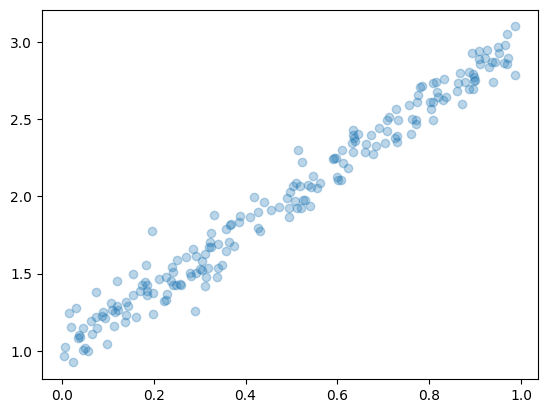

In [5]:
nr_points=200
np.random.seed(42)
x_train = np.random.rand(nr_points, 1)

a_true=2;
b_true=1;
y_train = b_true + a_true * x_train + .1 * np.random.randn(nr_points, 1)



plt.scatter(x_train,y_train,alpha=0.3)

(in descriptioins we abbreviate `x_train` as $x$ and `y_train` as $y$)

Goal: We want to "predict" $y$ given $x$ via finding "best" line. To be more exact, given $x$ we predict $$\hat{y}=ax+b.$$ We want to  find $a, b$ such that
$$error = loss =  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$ is minimalized.

Let us have a look how $f(a,b)$ looks like

drawing $f$, non-Python (slow, two `for` loops) way:

(40, 40)
Running time:  0.05469226837158203  s


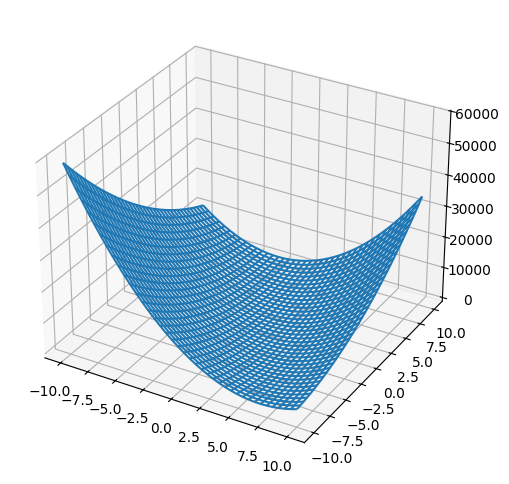

In [6]:


aa = np.linspace(-10,10,40)
bb = np.linspace(-10,10,40)
aa2,bb2=np.meshgrid(aa,bb)
print(aa2.shape)

t_start = time.time()

ff2=np.zeros(aa2.shape)
for i in np.arange(aa2.shape[0]):
  for j in np.arange(aa2.shape[1]):
    ff2[i,j]=np.sum((aa[i]*x_train+bb[j]-y_train)**2)

t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

drawing $f$,  Python   way:

Running time:  0.04116106033325195  s


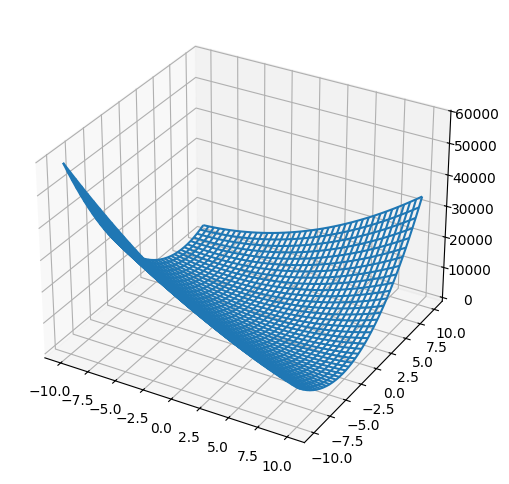

In [7]:

t_start = time.time()

aa2_expanded = aa2[:, np.newaxis, :]  # New shape: (40, 1, 40)
bb2_expanded = bb2[:, np.newaxis, :]  # New shape: (40, 1, 40)

ff2 = np.sum((aa2_expanded * x_train + bb2_expanded - y_train) ** 2, axis=1)
t_end = time.time()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot_wireframe(aa2,bb2,ff2)


print("Running time: ", t_end-t_start , " s")

# Gradient
In general, we may start with some $(a_0,b_0)$ and ($\rho$ -- learning rate)
$$(a_{t+1}, b_{t+1})  \leftarrow (a_t, b_t) - \rho \nabla f(a,b)|_{a=a_t, b=b_t}$$
In other words:
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t}$$
$\  $
$$b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$


## Computing partial derivatives <b>MANUALLY<b>
For this function  
$$ f(a,b)=(\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$f$ we have
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

## "Best solution" found -- using <tt>sklearn</tt> library (just to compare with our methods):

In [8]:
linr = LinearRegression()
linr.fit(x_train, y_train)
a_skl = linr.coef_[0].item()
b_skl = linr.intercept_.item()

print("a_skl = ", a_skl, ", b_skl = ", b_skl)

a_skl =  1.9921928931825028 , b_skl =  1.0105201150960823


# Stochastic gradient, iterative updates ($\rho$ - learning rate):
$$a_{t+1}  \leftarrow a_t - \rho{\partial \over \partial a} f(a,b)|_{a=a_t, b=b_t},\qquad \qquad
b_{t+1}  \leftarrow b_t - \rho{\partial \over \partial b} f(a,b)|_{a=a_t, b=b_t}$$

Text(0.5, 1.0, 'Loss (every 10 epochs)')

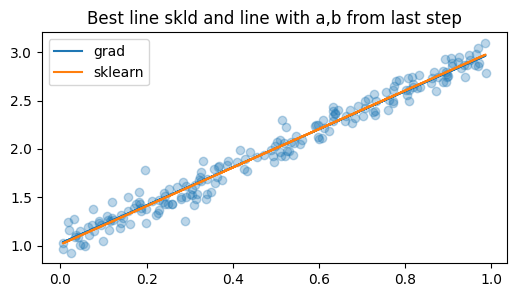

<Figure size 640x480 with 0 Axes>

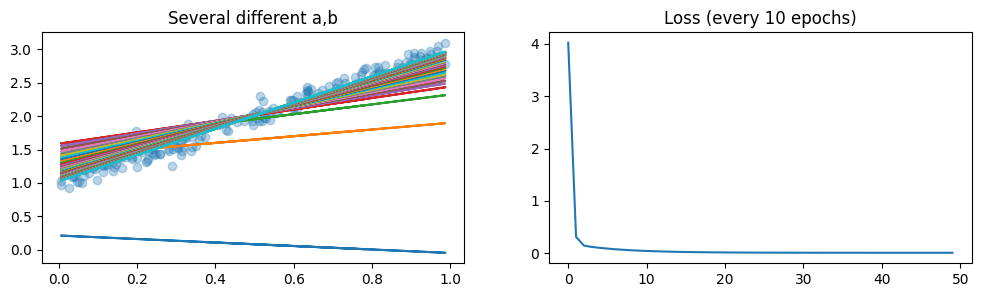

In [9]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b
np.random.seed(2)
a = np.random.normal(0,1)
b = np.random.normal(0,1)

# main iteration:
for epoch in range(n_epochs):
  grad_a = 2*np.mean((a*x_train+b-y_train)*x_train)    ## <- Again, we computed derivatives MANUALLY
  grad_b = 2*np.mean(a*x_train+b-y_train)

  a = a - lr*grad_a
  b = b - lr*grad_b

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a)
    b_list.append(b)
    loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a*x_train+b, label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

# Automatic differentation in torch

Again, mannually: $$  f(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 = {1\over n}\sum_{i=1}^n (a x_i + b-y_i)^2$$
$${\partial\over\partial a} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) x_i$$
$${\partial\over\partial b} f(a,b)  = {1\over n}\sum_{i=1}^n 2(ax_i+b-y_i) $$

Compute *MANUALLY* values of gradients at `a=2.0` and `b=4.0`

In [10]:
a=2.0
b=4.0

print("grad_a = ", 2*np.mean((a*x_train+b-y_train)*x_train))
print("grad_b = ",2*np.mean(a*x_train+b-y_train))

grad_a =  2.898862652293246
grad_b =  5.986517146534729


### a_tensor, b_tensor -- type "tensor", gradients will be computed:

In [11]:
# type 'tensor', can comptute gradients
a_tensor = torch.tensor(2.0, requires_grad=True)
b_tensor = torch.tensor(4.0, requires_grad=True)
print("a_tensor = ", a_tensor,", b_tensor = ", b_tensor)

a_tensor =  tensor(2., requires_grad=True) , b_tensor =  tensor(4., requires_grad=True)


We also need

In [12]:
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

In [13]:
x_train_tensor[:5]

tensor([[0.3745],
        [0.9507],
        [0.7320],
        [0.5987],
        [0.1560]])

Define  $loss$ (function $f$)

In [14]:
yhat = a_tensor * x_train_tensor + b_tensor
error = y_train_tensor - yhat
loss = torch.mean((error ** 2))
# == loss = torch.mean(torch.pow(x_train_tensor*a_tensor+b_tensor-y_train_tensor,2))
loss.backward()

print("grad_a (torch) = ", a_tensor.grad)
print("grad_b (torch) = ", b_tensor.grad)

print()

grad_a (torch) =  tensor(2.8989)
grad_b (torch) =  tensor(5.9865)



Text(0.5, 1.0, 'Loss (every 10 epochs)')

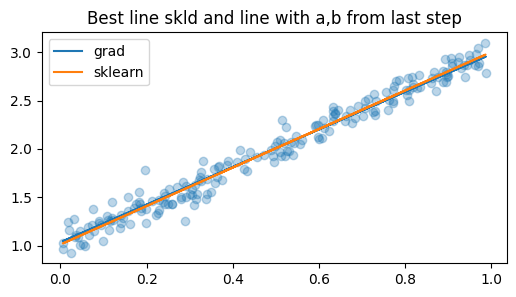

<Figure size 640x480 with 0 Axes>

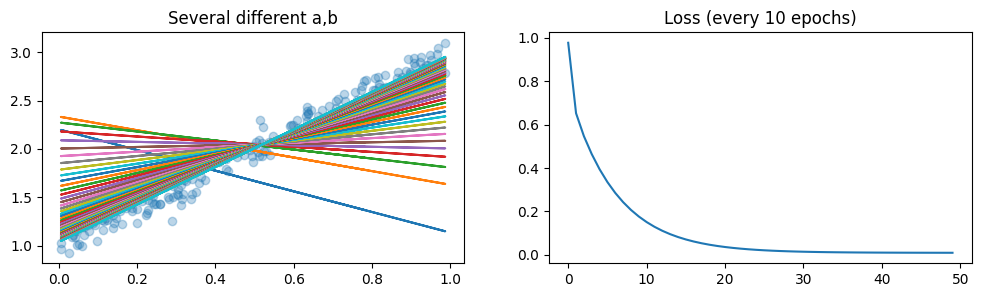

In [15]:
lr = 0.06
n_epochs = 500

loss_list = []
a_list =[]
b_list =[]

# random inital a, b

a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([a, b], lr=lr) # Stochastic Gradiend Descent
# optimizer = torch.optim.Adam([a, b], lr=lr) # More sophisticated method


# main iteration:
for epoch in range(n_epochs):

  yhat = a  * x_train_tensor + b
  error = y_train_tensor - yhat
  loss = torch.mean((error ** 2))

  loss.backward()

  optimizer.step()
  optimizer.zero_grad()

  #below is just for later figures:
  if ((epoch % 10)==0):
    a_list.append(a.item())
    b_list.append(b.item())
    #loss = np.mean((a * x_train + b-y_train)**2)
    loss_list.append(loss.item())


plt.figure(figsize=(6,3))
plt.scatter(x_train,y_train,alpha=0.3)
plt.plot(x_train,a.item()*x_train+b.item(), label = "grad")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "sklearn")
plt.title("Best line skld and line with a,b from last step")
plt.legend()

plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

axes[0].scatter(x_train,y_train,alpha=0.3)
axes[0].set_title("Several different a,b")
for i in np.arange(len(a_list)):

  aa=a_list[i]
  bb=b_list[i]
  axes[0].plot(x_train,aa*x_train+bb)

axes[1].plot(np.arange(len(loss_list)),loss_list)
axes[1].set_title("Loss (every 10 epochs)")

Above we **DID NOT FOLLOW `Good practice in Python for Machine Learning' FROM PREVIOUS LIST** !!!

Let's rewrite it "nicely":

In [16]:
class TorchLinearRegression1D:
    """
    A 1D linear regression model using PyTorch and gradient descent.

    Model: y = a * x + b

    This class provides .fit() and .predict() methods, and stores the training history.
    """
    def __init__(self, lr=0.06, n_epochs=500, optimizer_name="Adam", device=None):
        """
        Initialize the model with hyperparameters.

        Parameters:
            lr (float): Learning rate.
            n_epochs (int): Number of training epochs.
            optimizer_name (str): Optimizer to use ("SGD" or "Adam").
            device (torch.device): Device to run computations on. Defaults to CPU.
        """
        self.lr = lr
        self.n_epochs = n_epochs
        self.optimizer_name = optimizer_name
        self.device = device if device is not None else torch.device("cpu")
        self.a = None
        self.b = None
        self.loss_history = []
        self.a_history = []
        self.b_history = []

    def fit(self, x_train, y_train, verbose=False):
        """
        Train the model using gradient descent.

        Parameters:
            x_train (array-like): 1D array of input features.
            y_train (array-like): 1D array of target values.
            verbose (bool): If True, print loss every 10 epochs.

        Returns:
            self: Fitted estimator.
        """
        # Convert training data to torch tensors and ensure they are column vectors.
        x_train_tensor = torch.tensor(np.ravel(x_train), dtype=torch.float32, device=self.device).view(-1, 1)
        y_train_tensor = torch.tensor(np.ravel(y_train), dtype=torch.float32, device=self.device).view(-1, 1)

        # Initialize parameters a and b randomly, with gradient tracking.
        self.a = torch.randn(1, requires_grad=True, dtype=torch.float32, device=self.device)
        self.b = torch.randn(1, requires_grad=True, dtype=torch.float32, device=self.device)

        # Choose optimizer
        if self.optimizer_name.lower() == "sgd":
            optimizer = torch.optim.SGD([self.a, self.b], lr=self.lr)
        elif self.optimizer_name.lower() == "adam":
            optimizer = torch.optim.Adam([self.a, self.b], lr=self.lr)
        else:
            raise ValueError("Unsupported optimizer. Choose 'SGD' or 'Adam'.")

        # Reset histories
        self.loss_history = []
        self.a_history = []
        self.b_history = []

        # Main training loop
        for epoch in range(self.n_epochs):
            # Forward pass: compute predictions and loss.
            yhat = self.a * x_train_tensor + self.b
            error = y_train_tensor - yhat
            loss = torch.mean(error ** 2)

            # Backward pass: compute gradients.
            loss.backward()

            # Update parameters.
            optimizer.step()
            optimizer.zero_grad()

            # Record training history every 10 epochs.
            if epoch % 10 == 0:
                self.loss_history.append(loss.item())
                self.a_history.append(self.a.item())
                self.b_history.append(self.b.item())
                if verbose:
                    print(f"Epoch {epoch}: loss = {loss.item():.4f}")

        return self

    def predict(self, x):
        """
        Predict target values for new data.

        Parameters:
            x (array-like): 1D array of input features.

        Returns:
            np.ndarray: Predicted target values.
        """
        x_tensor = torch.tensor(np.ravel(x), dtype=torch.float32, device=self.device).view(-1, 1)
        y_pred = self.a * x_tensor + self.b
        return y_pred.detach().cpu().numpy().flatten()

In [17]:
# Create and train the model
model = TorchLinearRegression1D(lr=0.06, n_epochs=500, optimizer_name="SGD")
model.fit(x_train, y_train, verbose=True)

Epoch 0: loss = 14.4409
Epoch 10: loss = 0.8220
Epoch 20: loss = 0.2573
Epoch 30: loss = 0.2023
Epoch 40: loss = 0.1720
Epoch 50: loss = 0.1470
Epoch 60: loss = 0.1259
Epoch 70: loss = 0.1080
Epoch 80: loss = 0.0929
Epoch 90: loss = 0.0801
Epoch 100: loss = 0.0692
Epoch 110: loss = 0.0600
Epoch 120: loss = 0.0522
Epoch 130: loss = 0.0457
Epoch 140: loss = 0.0401
Epoch 150: loss = 0.0354
Epoch 160: loss = 0.0314
Epoch 170: loss = 0.0280
Epoch 180: loss = 0.0251
Epoch 190: loss = 0.0227
Epoch 200: loss = 0.0207
Epoch 210: loss = 0.0189
Epoch 220: loss = 0.0174
Epoch 230: loss = 0.0162
Epoch 240: loss = 0.0151
Epoch 250: loss = 0.0143
Epoch 260: loss = 0.0135
Epoch 270: loss = 0.0129
Epoch 280: loss = 0.0123
Epoch 290: loss = 0.0119
Epoch 300: loss = 0.0115
Epoch 310: loss = 0.0111
Epoch 320: loss = 0.0109
Epoch 330: loss = 0.0106
Epoch 340: loss = 0.0104
Epoch 350: loss = 0.0103
Epoch 360: loss = 0.0101
Epoch 370: loss = 0.0100
Epoch 380: loss = 0.0099
Epoch 390: loss = 0.0098
Epoch 400:

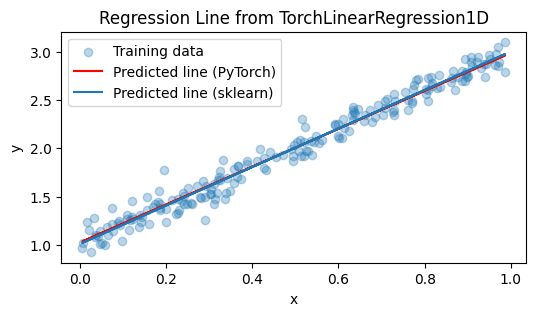

In [18]:
# Predict on the training data
y_pred = model.predict(x_train)

# Plot the final regression line (using the last parameters)
plt.figure(figsize=(6, 3))
plt.scatter(x_train, y_train, alpha=0.3, label='Training data')
plt.plot(x_train, y_pred, color='red', label="Predicted line (PyTorch)")
plt.plot(x_train ,a_skl*x_train +b_skl, label = "Predicted line (sklearn)")
plt.title("Regression Line from TorchLinearRegression1D")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

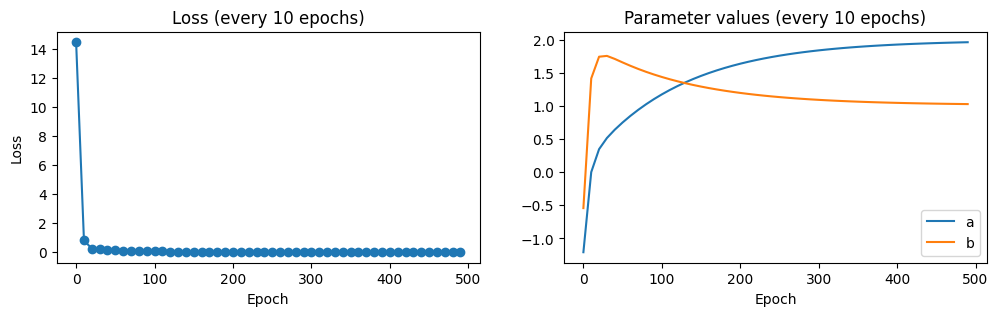

In [19]:
# Plot training history of parameters and loss
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
axes[0].plot(np.arange(0, model.n_epochs, 10), model.loss_history, marker='o')
axes[0].set_title("Loss (every 10 epochs)")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")

axes[1].plot(np.arange(0, model.n_epochs, 10), model.a_history, label='a')
axes[1].plot(np.arange(0, model.n_epochs, 10), model.b_history, label='b')
axes[1].set_title("Parameter values (every 10 epochs)")
axes[1].set_xlabel("Epoch")
axes[1].legend()
plt.show()

# Q2.1 (**10 pts**)
* Sample `x_test`, a vector of size 50 of i.i.d $\mathcal{U}(0,1)$ random variables and similarly compute corresponding

$\qquad$ `y_test = b_true + a_true * x_test + .1 * np.random.randn(nr_points, 1)`

* Take the model (aka `a` and `b`) trained on `(x_train,y_train)` (say, of size 200)  and compute final loss on test set, i.e.,
$$\textrm{loss}_{\rm final} = {1\over n}\sum_{i=1}^{n} (a\cdot x\_{test} + b - y_{test})^2$$
* Using SGD or Adam find new $a$ and $b$ minimizing function
$$g(a,b)={1\over n}\sum_{i=1}^n (\hat{y}_i-y_i)^2 + \lambda(a^2+b^2)$$
with $\lambda=0.1$
* Optimize    for `lambda>0` using `GridSearch` or `RandomizedSearch`. For fixed $\lambda$ find $\textrm{argmin}_{a,b} g(a,b)$ on the training set, and compute the $\textrm{loss}_{\rm final}$ on test set. Choose $\lambda$ that yields lowest $\textrm{loss}_{\rm final}$. Compare with $\lambda=0$ (i.e., original model).

# Q2.2 (**10 pts**)
On previous list we considered Ridge Regression for 1d data (exact solution was provided). Now consider Ridge Regresion for multidimensional data:
We are given data points
$$(\textbf{x}_1,y_1),\ldots,(\textbf{x}_n,y_n)$$
where each $x_i \in \mathbb{R}^d$, and our goal is to estimate parameters $\beta_0, \ldots, \beta_d$  such that the model
$$
y = \beta_0 + \beta_1 x_1+\ldots +\beta_d x_d
$$
"best" fits the data. By "best" we mean that the parameters minimize the loss function
$$
g(\beta_0,\beta_1,\ldots,\beta_d, \lambda)=\sum_{i=1}^n \Bigl(y_i-(\beta_0+\mathbf{x}_i^T \boldsymbol{\beta})\Bigr)^2 +\lambda\sum_{i=0}^d \beta_i^2,
$$
where $\boldsymbol{\beta} = (\beta_1, \beta_2, \ldots, \beta_d)^T$ and $\mathbf{x}_i=(x_{i1},\ldots,x_{id})^T$  and $\lambda\geq 0$ is a hyperparamter.
* a) Implement multidimensional Ridge Regression `myRidgeRegression_multiD()` using gradient method (note: just form of loss function is needed, make options `sgd` and `adam` available). Preferred: implementation using a class.
* b) Re-consider California House Pricing from previous list. Choose several values of $\lambda$ and compare results with `myLinearRegression_multiD()`
* c) Find "best" parameter lambda using `RandomizedSearchCV` (your implementation of `myRidgeRegression_multiD()` may require modification), search for it using uniform(0,5) distr., `cv=5` and `n_iter=100`. Compare model with best $\lambda$ found this way with previous models.




# Many more parameters to optimize.. e.g., **matrices**
Parameters we optimize do not have to be scalars, they can be vectors, matrices,...

Say we are given $\mathbf{Z}$ of size $n\times d$ and want to represent it as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$

No restrictions on entries of $\mathbf{W}$ and $\mathbf{H}$, goal is to minimize some $dist(\mathbf{Z},\mathbf{W}\mathbf{H})$, e.g. Frob:
 $$dist_{Frob}(\mathbf{Z},\mathbf{W}\mathbf{H})=||\mathbf{Z}-\mathbf{W}\mathbf{H}||^2=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^2$$

In [20]:
d=15
n=11
Z = torch.randint(0,10,(n,d))
print(Z)

tensor([[4, 6, 4, 3, 6, 7, 7, 2, 4, 8, 3, 1, 8, 2, 8],
        [7, 4, 8, 3, 7, 6, 8, 1, 7, 9, 2, 0, 0, 7, 1],
        [6, 7, 0, 7, 3, 7, 7, 5, 2, 4, 9, 0, 0, 2, 1],
        [3, 3, 6, 9, 9, 9, 5, 1, 8, 1, 0, 0, 7, 2, 0],
        [7, 3, 8, 9, 9, 6, 3, 3, 0, 5, 3, 2, 4, 6, 1],
        [7, 1, 3, 8, 4, 5, 7, 4, 3, 5, 1, 5, 4, 8, 9],
        [5, 7, 8, 1, 4, 5, 2, 3, 7, 1, 2, 0, 6, 0, 0],
        [2, 0, 1, 5, 7, 8, 6, 0, 3, 9, 2, 6, 4, 9, 0],
        [7, 5, 8, 0, 4, 9, 5, 7, 6, 5, 8, 7, 9, 2, 2],
        [6, 4, 7, 0, 2, 4, 5, 0, 1, 8, 4, 6, 7, 8, 3],
        [4, 3, 0, 0, 5, 3, 2, 4, 1, 0, 8, 6, 9, 2, 3]])


Set r, sample random matrices  $\mathbf{H}, \mathbf{W}$  (each entry  $\mathcal{N}$(0,1)  i.i.d)

In [21]:
r=2
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)
print(W,"\n",H)

tensor([[-0.5221, -0.2357],
        [-0.4106, -0.4554],
        [-1.1453,  0.8475],
        [-0.8086, -1.1811],
        [ 0.0886,  1.5909],
        [ 1.0583,  0.4347],
        [-0.9498,  0.4567],
        [-0.6272,  1.0922],
        [-0.4535, -0.0251],
        [-0.7545,  0.4046],
        [ 1.5587,  2.1377]], requires_grad=True) 
 tensor([[ 0.7520, -0.2259,  1.0883,  2.5601, -0.2543,  0.2836,  0.6004,  0.8537,
         -1.9388,  0.0980, -0.6984, -0.2659, -0.8916, -0.2278,  2.0795],
        [-0.3260, -1.0113,  1.6187, -1.1190, -1.2025, -0.2000, -1.0282,  0.7620,
         -0.8173,  1.0219, -0.0938,  0.8005, -0.5637,  0.6266, -0.8558]],
       requires_grad=True)


In [22]:
loss=torch.sum(torch.pow(Z-torch.matmul(W,H),2))
print(loss)

tensor(4905.5776, grad_fn=<SumBackward0>)


Nr of parameters = n*r+r*d=

In [23]:
print("Nr of parameters in Z : ", n*d)
print("Nr of parameters in H and W : ",n*r+r*d)
print("Fraction/reduction: ", np.round((n*r+r*d)/(n*d),4))

Nr of parameters in Z :  165
Nr of parameters in H and W :  52
Fraction/reduction:  0.3152


tensor(3.4765, grad_fn=<MeanBackward0>)
final loss2 =  3.4765195846557617


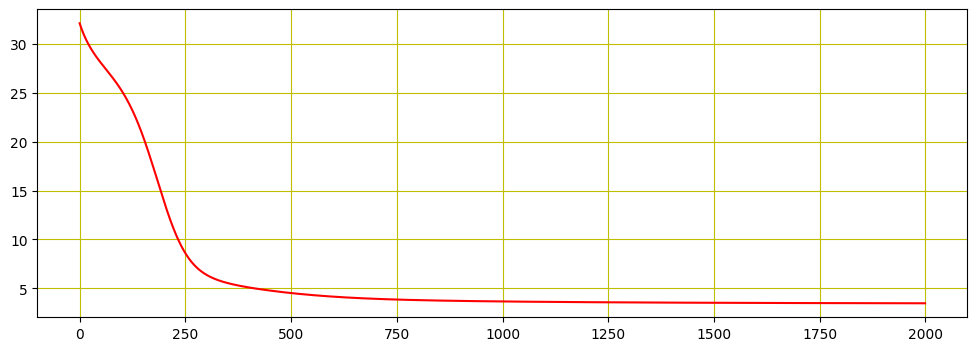

In [24]:

lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):

    # just define loss! everything less automatic
    loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- MAIN ONE


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss=loss.item()
print("final loss2 = ", loss.item())


In [25]:
print("W = ", W, "\nH=",H)

W =  tensor([[-1.2044, -1.9327, -1.3673],
        [ 0.5572, -2.2911, -1.9025],
        [-0.0280, -2.2355, -0.4755],
        [ 0.7690, -3.0570, -0.1690],
        [ 0.1758, -2.2110, -1.6178],
        [-0.6540, -1.1891, -2.8611],
        [-0.6971, -2.4597,  0.8825],
        [-0.1615, -1.1054, -2.9133],
        [-2.5744, -2.4119, -0.3212],
        [-1.9451, -0.8204, -2.2920],
        [-2.5285, -0.9465, -0.2328]], requires_grad=True) 
H= tensor([[-0.8544, -0.8265, -0.4725,  1.5658,  0.2610, -0.3474, -0.1235, -1.0564,
          0.0277, -0.3142, -1.8761, -2.0032, -2.5796, -0.0693, -1.1408],
        [-1.8665, -1.9678, -2.2233, -1.9419, -2.3421, -2.6729, -1.7134, -1.1984,
         -2.1769, -1.0327, -1.2893, -0.0094, -1.6395, -0.5105, -0.1444],
        [-0.9263,  0.3865, -0.3579, -1.2811, -0.9837, -0.8495, -1.5578,  0.2454,
          0.1721, -2.4093,  0.0847, -1.2122, -0.1769, -2.7263, -1.2007]],
       requires_grad=True)


Recovered $\mathbf{Z}$:


In [26]:
print("Recovered (rounded) Z, i.e., W*H = \n ",np.round(torch.matmul(W,H).detach().numpy(),2))
print("Original Z = \n ",np.round(Z.detach().numpy(),2))


Recovered (rounded) Z, i.e., W*H = 
  [[ 5.9   4.27  5.36  3.62  5.56  6.75  5.59  3.25  3.94  5.67  4.64  4.09
   6.52  4.8   3.29]
 [ 5.56  3.31  5.51  7.76  7.38  7.55  6.82  1.69  4.68  6.77  1.75  1.21
   2.66  6.32  1.98]
 [ 4.64  4.24  5.15  4.91  5.7   6.39  4.57  2.59  4.78  3.46  2.89  0.65
   3.82  2.44  0.93]
 [ 5.21  5.31  6.49  7.36  7.53  8.05  5.41  2.81  6.65  3.32  2.48 -1.31
   3.06  1.97 -0.23]
 [ 5.48  3.58  5.41  6.64  6.82  7.22  6.29  2.07  4.54  6.13  2.38  1.63
   3.46  5.53  2.06]
 [ 5.43  1.77  3.98  4.95  5.43  5.84  6.58  1.41  2.08  8.33  2.52  4.79
   4.14  8.45  4.35]
 [ 4.37  5.76  5.48  2.55  4.71  6.07  2.93  3.9   5.49  0.63  4.55  0.35
   5.67 -1.1   0.09]
 [ 4.9   1.18  3.58  5.63  5.41  5.49  6.45  0.78  1.9   8.21  1.48  3.87
   2.74  8.52  3.84]
 [ 7.    6.75  6.69  1.06  5.29  7.61  4.95  5.53  5.12  4.07  7.91  5.57
  10.65  2.29  3.67]
 [ 5.32  2.34  3.56  1.48  3.67  4.82  5.22  2.48  1.34  6.98  4.51  6.68
   6.77  6.8   5.09]
 [ 4.14  3.8

## Non-negative matrices Matrices  $\mathbf{W},\mathbf{H} $

Note that currently found matrices are NOT non-negative

In [27]:
print(W,"\n",H)

tensor([[-1.2044, -1.9327, -1.3673],
        [ 0.5572, -2.2911, -1.9025],
        [-0.0280, -2.2355, -0.4755],
        [ 0.7690, -3.0570, -0.1690],
        [ 0.1758, -2.2110, -1.6178],
        [-0.6540, -1.1891, -2.8611],
        [-0.6971, -2.4597,  0.8825],
        [-0.1615, -1.1054, -2.9133],
        [-2.5744, -2.4119, -0.3212],
        [-1.9451, -0.8204, -2.2920],
        [-2.5285, -0.9465, -0.2328]], requires_grad=True) 
 tensor([[-0.8544, -0.8265, -0.4725,  1.5658,  0.2610, -0.3474, -0.1235, -1.0564,
          0.0277, -0.3142, -1.8761, -2.0032, -2.5796, -0.0693, -1.1408],
        [-1.8665, -1.9678, -2.2233, -1.9419, -2.3421, -2.6729, -1.7134, -1.1984,
         -2.1769, -1.0327, -1.2893, -0.0094, -1.6395, -0.5105, -0.1444],
        [-0.9263,  0.3865, -0.3579, -1.2811, -0.9837, -0.8495, -1.5578,  0.2454,
          0.1721, -2.4093,  0.0847, -1.2122, -0.1769, -2.7263, -1.2007]],
       requires_grad=True)


Simple "softmax" trick:

tensor(3.8745, grad_fn=<MeanBackward0>)
final_loss =  3.4765195846557617
final_loss_nonneg =  3.874472141265869


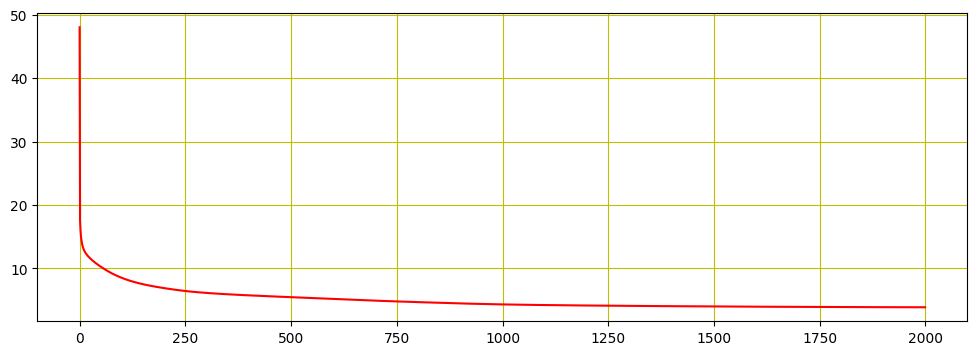

In [28]:
lr = 0.02
n_epochs = 2000

r=3
W = torch.randn((n,r), requires_grad=True, dtype=torch.float, device=device)
H = torch.randn((r,d), requires_grad=True, dtype=torch.float, device=device)


optimizer = torch.optim.SGD([W, H], lr=lr)
#optimizer = torch.optim.Adam([W, H], lr=lr)

loss_list = []

for epoch in range(n_epochs):


    # loss=torch.mean(torch.pow(Z-torch.matmul(W,H),2))   ## <- OLD


    W2 = torch.exp(W)
    H2 = torch.exp(H)

    loss=torch.mean(torch.pow(Z-torch.matmul(W2,H2),2))


    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())

print(loss)


#fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,4))
plt.figure(figsize=(12,4))
plt.plot(loss_list, 'r')
plt.grid('True', color='y')


final_loss_nonneg=loss.item()
print("final_loss = ", final_loss)
print("final_loss_nonneg = ", final_loss_nonneg)

In [29]:
# Final matrices:
W2 = torch.exp(W)
H2 = torch.exp(H)

In [30]:
print(W2)
print(H2)


tensor([[1.2493, 1.1951, 1.9485],
        [1.9433, 1.8761, 0.2708],
        [1.0001, 1.9345, 0.1680],
        [0.3011, 3.3210, 0.2663],
        [1.4181, 2.1375, 0.3818],
        [2.1372, 0.7336, 1.2021],
        [0.0859, 2.2937, 0.9200],
        [2.4623, 0.4467, 0.6677],
        [0.1690, 1.5240, 3.6889],
        [1.5949, 0.1933, 2.3836],
        [0.1298, 0.3053, 3.1160]], grad_fn=<ExpBackward0>)
tensor([[1.4454, 0.2862, 0.5411, 1.5959, 1.5950, 1.4838, 2.3605, 0.2350, 0.2232,
         3.3546, 0.2814, 0.7182, 0.2740, 3.3905, 1.1039],
        [1.4251, 1.5974, 2.1034, 1.7745, 2.1284, 2.2274, 1.1256, 0.8765, 2.0028,
         0.2497, 0.6757, 0.1187, 1.0503, 0.2155, 0.1354],
        [1.1448, 0.9269, 0.9561, 0.0711, 0.3669, 1.0163, 0.6628, 0.9588, 0.5679,
         0.7080, 1.7716, 1.6928, 2.5265, 0.2536, 0.9866]],
       grad_fn=<ExpBackward0>)


# Q2.3 (**10 pts**)
Consider matrix $Z$:

```python
d=15
n=11
Z = torch.randint(0,10,(n,d))
print(Z)
```

A)
* Perform Truncated SVD, i.e., decompose $\mathbf{Z}=\mathbf{U}\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$, denote $\mathbf{W}=\mathbf{U}, \mathbf{H}=\mathbf{\Lambda}^{1\over 2} \mathbf{V}^T$. Then approximate $\mathbf{Z}$ by $\mathbf{Z}_r=\mathbf{W}_r \mathbf{H}_r$. Compare with SGD/Adam methods for various values of $r$. What are the conclusions?
* Consider different distance
 $$dist_{4}(\mathbf{Z},\mathbf{W}\mathbf{H})=\sum_{i,j} (\mathbf{Z}[i,j] -(\mathbf{W}\mathbf{H})[i,j])^4$$
 Find "best" matrices $\mathbf{W}, \mathbf{H}$ using SGD/Adam methods. Compare with distance computed for truncated SVD.

B)
* Approximate (still use $dist_4$) the same  $\mathbf{Z}$ as
$$\mathbf{Z}\approx \mathbf{W}\mathbf{H}$$
where $\mathbf{W}$ is of size $n\times r$ and $\mathbf{H}$ is of size $r\times d$ (fix some $r<d$) so that
* a) Columns of $\mathbf{W}$ are probability distributions (i.e., non-negative summing up to 1)
* b) Columns of $\mathbf{W}$ and rows of $\mathbf{H}$ are probability distributions
* c) $\mathbf{W}$ is non-negatvie and each entry of $\mathbf{H}$ is at least 0.5
